### Initialization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
from src.utils.simulator import batch_simulator
from scipy.stats import gaussian_kde
import torch
from os import cpu_count
from sbi import utils as utils
import divergences
from concurrent.futures import ProcessPoolExecutor
from helper_functions import sample_from_posterior, build_theta_for_batch_simulator_from_samples_tensor, plot_angular_velocity
from matplotlib.lines import Line2D

In [2]:
f_ref = 50
time_span = 60
n_workers = cpu_count() # Number of parallel workers for the simulator

### Continental Europe (CE)

In [3]:
## Processing 2021 CE dataset
df = pd.read_csv("2021.csv", header=None)
df.columns = ["date", "freq"]
df["angular_velocity"] = 2 * np.pi * (df["freq"] - f_ref)
df.index = pd.to_datetime(df["date"])

#### Parameter Estimation with Fixed Inertia

##### General posterior (60min)

In [4]:
number_of_samples = 500
time_span = 3600
days = 90
hours = 24 # 24 hours in a day
dt = 1.0 # because the divergence plots take too long for dt=0.01

In [5]:
# read in the prior
in_s = open("out/prior_3600s.pickle", "rb")
try:
    prior = pickle.load(in_s)
finally:
    in_s.close()

In [6]:
# read in the posterior
in_s = open("out/posterior_NPE_3600s_dt" + str(dt) + ".pickle", "rb")
try:
    posterior_NPE = pickle.load(in_s)
finally:
    in_s.close()

In [7]:
# compute the data used for the daily parameter profiles. this includes the means and the 25th and 75th percentiles for each parameter and each hour of each day

start = datetime.datetime(2021, 1, 1, 0, 0, 0)

c1_means = np.zeros((days, hours))
c1_q25 = np.zeros((days, hours))
c1_q75 = np.zeros((days, hours))

c2_means = np.zeros((days, hours))
c2_q25 = np.zeros((days, hours))
c2_q75 = np.zeros((days, hours))

p0_means = np.zeros((days, hours))
p0_q25 = np.zeros((days, hours))
p0_q75 = np.zeros((days, hours))

p1_means = np.zeros((days, hours))
p1_q25 = np.zeros((days, hours))
p1_q75 = np.zeros((days, hours))

for j in range(0, days):
    day = start.day

    for i in range(0, hours):
        end = start + datetime.timedelta(minutes=59, seconds=59)

        # we take a 60-minute long observation
        x_obs = df[str(start):str(end)]["angular_velocity"].to_numpy()
        
        # print current day and hour for debugging
        # print("Day: " + str(day) + ", Hour: " + str(start.hour))

        # if the observation is empty or contains NaNs, we skip it
        if (x_obs.size == 0 or np.any(np.isnan(x_obs))):
            c1_means[j][i] = np.nan
            c1_q25[j][i] = np.nan
            c1_q75[j][i] = np.nan

            c2_means[j][i] = np.nan
            c2_q25[j][i] = np.nan
            c2_q75[j][i] = np.nan

            p0_means[j][i] = np.nan
            p0_q25[j][i] = np.nan
            p0_q75[j][i] = np.nan

            p1_means[j][i] = np.nan
            p1_q25[j][i] = np.nan
            p1_q75[j][i] = np.nan

            start = start + datetime.timedelta(minutes=60)
            continue
        
        samples_NPE = sample_from_posterior(posterior_NPE, number_of_samples, x_obs)

        c1_means[j][i] = samples_NPE[:, 2].mean().item()
        c1_q25[j][i] = np.quantile(samples_NPE[:, 2].numpy(), 0.25)
        c1_q75[j][i] = np.quantile(samples_NPE[:, 2].numpy(), 0.75)
        
        c2_means[j][i] = samples_NPE[:, 3].mean().item()
        c2_q25[j][i] = np.quantile(samples_NPE[:, 3].numpy(), 0.25)
        c2_q75[j][i] = np.quantile(samples_NPE[:, 3].numpy(), 0.75)

        p0_means[j][i] = samples_NPE[:, 4].mean().item()
        p0_q25[j][i] = np.quantile(samples_NPE[:, 4].numpy(), 0.25)
        p0_q75[j][i] = np.quantile(samples_NPE[:, 4].numpy(), 0.75)

        p1_means[j][i] = samples_NPE[:, 5].mean().item()
        p1_q25[j][i] = np.quantile(samples_NPE[:, 5].numpy(), 0.25)
        p1_q75[j][i] = np.quantile(samples_NPE[:, 5].numpy(), 0.75)

        start = start + datetime.timedelta(minutes=60)

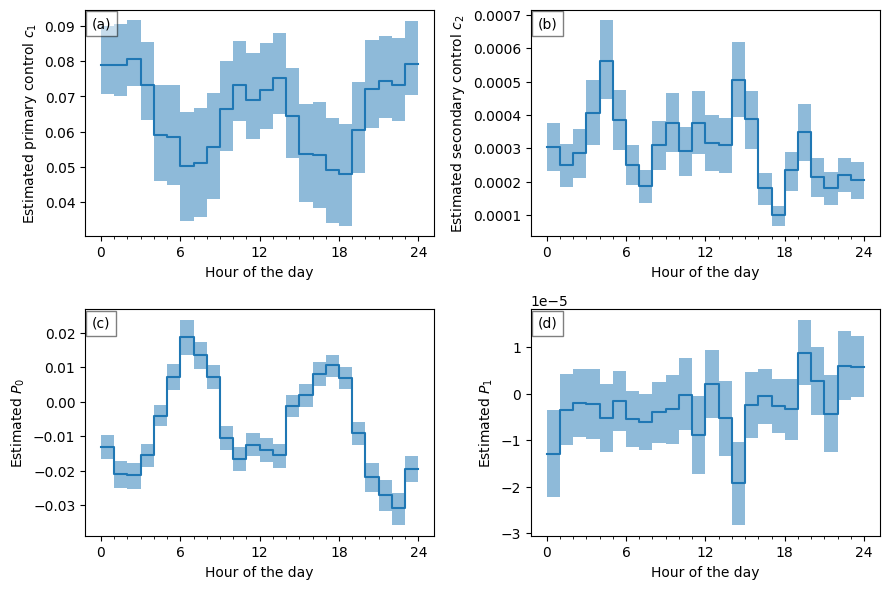

In [ ]:
# generates the combined plot of parameter daily profiles of c_1, c_2, P_0, and P_1
# the highlighted area around the mean line represents the 25th and 75th percentiles
fig, axs = plt.subplots(2, 2, figsize=(9, 6))
x = np.arange(0, hours + 1)

# set the x-axis ticks
for ax_row in axs:
    for ax in ax_row:
        ax.set_xticks([0, 6, 12, 18, 24])
        ax.set_xticks(np.arange(0, 25, 1), minor=True)
        ax.set_xlabel("Hour of the day")

# first subplot: daily profile of c_1
y = np.zeros(hours + 1)
for i in range(0, hours):
    y[i] = np.nanmean(c1_means[:, i])
y[-1] = y[-2]
axs[0][0].plot(x, y, drawstyle="steps-post")
axs[0][0].fill_between(x, 
                       np.append(np.nanmean(c1_q25, axis=0), np.nanmean(c1_q25, axis=0)[-1]), 
                       np.append(np.nanmean(c1_q75, axis=0), np.nanmean(c1_q75, axis=0)[-1]), alpha=0.5, step="post")
axs[0][0].set_ylabel(r"Estimated primary control $c_1$")
axs[0][0].text(0.02, 0.97, "(a)", transform=axs[0][0].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))

# second subplot: daily profile of c_2
y = np.zeros(hours + 1)
for i in range(0, hours):
    y[i] = np.nanmean(c2_means[:, i])
y[-1] = y[-2]
axs[0][1].plot(x, y, drawstyle="steps-post")
axs[0][1].fill_between(x, 
                       np.append(np.nanmean(c2_q25, axis=0), np.nanmean(c2_q25, axis=0)[-1]), 
                       np.append(np.nanmean(c2_q75, axis=0), np.nanmean(c2_q75, axis=0)[-1]), alpha=0.5, step="post")
axs[0][1].set_ylabel(r"Estimated secondary control $c_2$")
axs[0][1].text(0.02, 0.97, "(b)", transform=axs[0][1].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))

# third subplot: daily profile of P_0
y = np.zeros(hours + 1)
for i in range(0, hours):
    y[i] = np.nanmean(p0_means[:, i])
y[-1] = y[-2]
axs[1][0].plot(x, y, drawstyle="steps-post")
axs[1][0].fill_between(x, 
                       np.append(np.nanmean(p0_q25, axis=0), np.nanmean(p0_q25, axis=0)[-1]),
                       np.append(np.nanmean(p0_q75, axis=0), np.nanmean(p0_q75, axis=0)[-1]), alpha=0.5, step="post")
axs[1][0].set_ylabel(r"Estimated $P_0$")
axs[1][0].text(0.02, 0.97, "(c)", transform=axs[1][0].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))

# fourth subplot: daily profile of P_1
y = np.zeros(hours + 1)
for i in range(0, hours):
    y[i] = np.nanmean(p1_means[:, i])
y[-1] = y[-2]
axs[1][1].plot(x, y, drawstyle="steps-post")
axs[1][1].fill_between(x, 
                       np.append(np.nanmean(p1_q25, axis=0), np.nanmean(p1_q25, axis=0)[-1]),
                       np.append(np.nanmean(p1_q75, axis=0), np.nanmean(p1_q75, axis=0)[-1]), alpha=0.5, step="post")
axs[1][1].set_ylabel(r"Estimated $P_1$")
axs[1][1].text(0.02, 0.97, "(d)", transform=axs[1][1].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))

plt.tight_layout()
plt.savefig("figures/empirical_evaluation_CE_daily_profiles_60min.pdf", bbox_inches="tight", format="pdf")
plt.show()

##### General posterior (15min)

In [ ]:
number_of_samples = 500
time_span = 900
days = 90
hours = 24 # 24 hours in a day
dt = 0.01 # due to the shorter time_span, using a smaller step size dt becomes possible

In [15]:
# read in the posterior
in_s = open("out/posterior_NPE_900s_dt" + str(dt) + ".pickle", "rb")
try:
    posterior_NPE = pickle.load(in_s)
finally:
    in_s.close()

In [16]:
# compute the data used for the daily parameter profiles. this includes the means and the 25th and 75th percentiles for each parameter and each hour of each day
start = datetime.datetime(2021, 1, 1, 0, 0, 0)

c1_means = np.zeros((days, hours * 4))
c1_q25 = np.zeros((days, hours * 4))
c1_q75 = np.zeros((days, hours * 4))

c2_means = np.zeros((days, hours * 4))
c2_q25 = np.zeros((days, hours * 4))
c2_q75 = np.zeros((days, hours * 4))

p0_means = np.zeros((days, hours * 4))
p0_q25 = np.zeros((days, hours * 4))
p0_q75 = np.zeros((days, hours * 4))

p1_means = np.zeros((days, hours * 4))
p1_q25 = np.zeros((days, hours * 4))
p1_q75 = np.zeros((days, hours * 4))

for j in range(0, days):
    day = start.day

    for i in range(0, hours * 4):
        end = start + datetime.timedelta(minutes=14, seconds=59)

        # we take a 15-minute long observation
        x_obs = df[str(start):str(end)]["angular_velocity"].to_numpy()
        
        # print current day and hour for debugging
        # print("Day: " + str(day) + ", Hour: " + str(start.hour))

        # if the observation is empty or contains NaNs, we skip it
        if (x_obs.size == 0 or np.any(np.isnan(x_obs))):
            c1_means[j][i] = np.nan
            c1_q25[j][i] = np.nan
            c1_q75[j][i] = np.nan

            c2_means[j][i] = np.nan
            c2_q25[j][i] = np.nan
            c2_q75[j][i] = np.nan

            p0_means[j][i] = np.nan
            p0_q25[j][i] = np.nan
            p0_q75[j][i] = np.nan

            p1_means[j][i] = np.nan
            p1_q25[j][i] = np.nan
            p1_q75[j][i] = np.nan

            start = start + datetime.timedelta(minutes=15)
            continue
        
        samples_NPE = sample_from_posterior(posterior_NPE, number_of_samples, x_obs)

        c1_means[j][i] = samples_NPE[:, 2].mean().item()
        c1_q25[j][i] = np.quantile(samples_NPE[:, 2].numpy(), 0.25)
        c1_q75[j][i] = np.quantile(samples_NPE[:, 2].numpy(), 0.75)
        
        c2_means[j][i] = samples_NPE[:, 3].mean().item()
        c2_q25[j][i] = np.quantile(samples_NPE[:, 3].numpy(), 0.25)
        c2_q75[j][i] = np.quantile(samples_NPE[:, 3].numpy(), 0.75)

        p0_means[j][i] = samples_NPE[:, 4].mean().item()
        p0_q25[j][i] = np.quantile(samples_NPE[:, 4].numpy(), 0.25)
        p0_q75[j][i] = np.quantile(samples_NPE[:, 4].numpy(), 0.75)

        p1_means[j][i] = samples_NPE[:, 5].mean().item()
        p1_q25[j][i] = np.quantile(samples_NPE[:, 5].numpy(), 0.25)
        p1_q75[j][i] = np.quantile(samples_NPE[:, 5].numpy(), 0.75)

        start = start + datetime.timedelta(minutes=15)

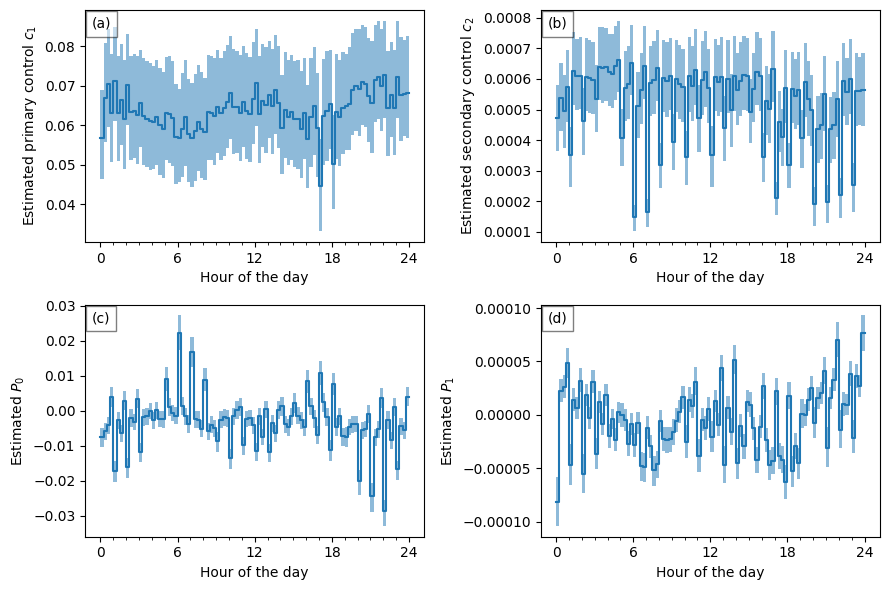

In [ ]:
# generates the combined plot of parameter daily profiles of c_1, c_2, P_0, and P_1
# the highlighted area around the mean line represents the 25th and 75th percentiles
fig, axs = plt.subplots(2, 2, figsize=(9, 6))
x = np.arange(0, 24 + 1/4, 1/4)

# set the x-axis ticks
for ax_row in axs:
    for ax in ax_row:
        ax.set_xticks([0, 6, 12, 18, 24])
        ax.set_xticks(np.arange(0, 25, 1), minor=True)
        ax.set_xlabel("Hour of the day")

# first subplot: daily profile of c_1
y = np.zeros(hours * 4 + 1)
for i in range(0, hours * 4):
    y[i] = np.nanmean(c1_means[:, i])
y[-1] = y[-2]
axs[0][0].plot(x, y, drawstyle="steps-post")
axs[0][0].fill_between(x, 
                       np.append(np.nanmean(c1_q25, axis=0), np.nanmean(c1_q25, axis=0)[-1]), 
                       np.append(np.nanmean(c1_q75, axis=0), np.nanmean(c1_q75, axis=0)[-1]), alpha=0.5, step="post")
axs[0][0].set_ylabel(r"Estimated primary control $c_1$")
axs[0][0].text(0.02, 0.97, "(a)", transform=axs[0][0].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))

# second subplot: daily profile of c_2
y = np.zeros(hours * 4 + 1)
for i in range(0, hours * 4):
    y[i] = np.nanmean(c2_means[:, i])
y[-1] = y[-2]
axs[0][1].plot(x, y, drawstyle="steps-post")
axs[0][1].fill_between(x, 
                       np.append(np.nanmean(c2_q25, axis=0), np.nanmean(c2_q25, axis=0)[-1]),
                        np.append(np.nanmean(c2_q75, axis=0), np.nanmean(c2_q75, axis=0)[-1]), alpha=0.5, step="post")
axs[0][1].set_ylabel(r"Estimated secondary control $c_2$")
axs[0][1].text(0.02, 0.97, "(b)", transform=axs[0][1].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))

# third subplot: daily profile of P_0
y = np.zeros(hours * 4 + 1)
for i in range(0, hours * 4):
    y[i] = np.nanmean(p0_means[:, i])
y[-1] = y[-2]
axs[1][0].plot(x, y, drawstyle="steps-post")
axs[1][0].fill_between(x, 
                       np.append(np.nanmean(p0_q25, axis=0), np.nanmean(p0_q25, axis=0)[-1]), 
                       np.append(np.nanmean(p0_q75, axis=0), np.nanmean(p0_q75, axis=0)[-1]), alpha=0.5, step="post")
axs[1][0].set_ylabel(r"Estimated $P_0$")
axs[1][0].text(0.02, 0.97, "(c)", transform=axs[1][0].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))

# fourth subplot: daily profile of P_1
y = np.zeros(hours * 4 + 1)
for i in range(0, hours * 4):
    y[i] = np.nanmean(p1_means[:, i])
y[-1] = y[-2]
axs[1][1].plot(x, y, drawstyle="steps-post")
axs[1][1].fill_between(x, 
                       np.append(np.nanmean(p1_q25, axis=0), np.nanmean(p1_q25, axis=0)[-1]), 
                       np.append(np.nanmean(p1_q75, axis=0), np.nanmean(p1_q75, axis=0)[-1]), alpha=0.5, step="post")
axs[1][1].set_ylabel(r"Estimated $P_1$")
axs[1][1].text(0.02, 0.97, "(d)", transform=axs[1][1].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))

plt.tight_layout()
plt.savefig("figures/empirical_evaluation_CE_daily_profiles_15min.pdf", bbox_inches="tight", format="pdf")
plt.show()

##### Daytime-specific posteriors (15min)

In [ ]:
number_of_samples = 500
time_span = 900
days = 90
hours = 24 # 24 hours in a day
dt = 0.01

In [ ]:
# compute the data used for the daily parameter profiles. this includes the means and the 25th and 75th percentiles for each parameter and each hour of each day

start = datetime.datetime(2021, 1, 1, 0, 0, 0)

c1_means = np.zeros((days, hours * 4))
c1_q25 = np.zeros((days, hours * 4))
c1_q75 = np.zeros((days, hours * 4))

c2_means = np.zeros((days, hours * 4))
c2_q25 = np.zeros((days, hours * 4))
c2_q75 = np.zeros((days, hours * 4))

p0_means = np.zeros((days, hours * 4))
p0_q25 = np.zeros((days, hours * 4))
p0_q75 = np.zeros((days, hours * 4))

p1_means = np.zeros((days, hours * 4))
p1_q25 = np.zeros((days, hours * 4))
p1_q75 = np.zeros((days, hours * 4))

for j in range(0, days):
    day = start.day

    for i in range(0, hours * 4):
        # read in the daytime-specific posterior
        in_s = open("out/posterior_NPE_900s_hour_" + str(start.hour) + "_dt0.01.pickle", "rb")
        try:
            posterior_NPE = pickle.load(in_s)
        finally:
            in_s.close()

        end = start + datetime.timedelta(minutes=14, seconds=59)

        # we take a 15-minute long observation
        x_obs = df[str(start):str(end)]["angular_velocity"].to_numpy()
        
        # print current day and hour for debugging
        # print("Day: " + str(day) + ", Hour: " + str(start.hour))

        # if the observation is empty or contains NaNs, we skip it
        if (x_obs.size == 0 or np.any(np.isnan(x_obs))):
            c1_means[j][i] = np.nan
            c1_q25[j][i] = np.nan
            c1_q75[j][i] = np.nan

            c2_means[j][i] = np.nan
            c2_q25[j][i] = np.nan
            c2_q75[j][i] = np.nan

            p0_means[j][i] = np.nan
            p0_q25[j][i] = np.nan
            p0_q75[j][i] = np.nan

            p1_means[j][i] = np.nan
            p1_q25[j][i] = np.nan
            p1_q75[j][i] = np.nan

            start = start + datetime.timedelta(minutes=15)
            continue
        
        samples_NPE = sample_from_posterior(posterior_NPE, number_of_samples, x_obs)

        c1_means[j][i] = samples_NPE[:, 2].mean().item()
        c1_q25[j][i] = np.quantile(samples_NPE[:, 2].numpy(), 0.25)
        c1_q75[j][i] = np.quantile(samples_NPE[:, 2].numpy(), 0.75)
        
        c2_means[j][i] = samples_NPE[:, 3].mean().item()
        c2_q25[j][i] = np.quantile(samples_NPE[:, 3].numpy(), 0.25)
        c2_q75[j][i] = np.quantile(samples_NPE[:, 3].numpy(), 0.75)

        p0_means[j][i] = samples_NPE[:, 4].mean().item()
        p0_q25[j][i] = np.quantile(samples_NPE[:, 4].numpy(), 0.25)
        p0_q75[j][i] = np.quantile(samples_NPE[:, 4].numpy(), 0.75)

        p1_means[j][i] = samples_NPE[:, 5].mean().item()
        p1_q25[j][i] = np.quantile(samples_NPE[:, 5].numpy(), 0.25)
        p1_q75[j][i] = np.quantile(samples_NPE[:, 5].numpy(), 0.75)

        start = start + datetime.timedelta(minutes=15)

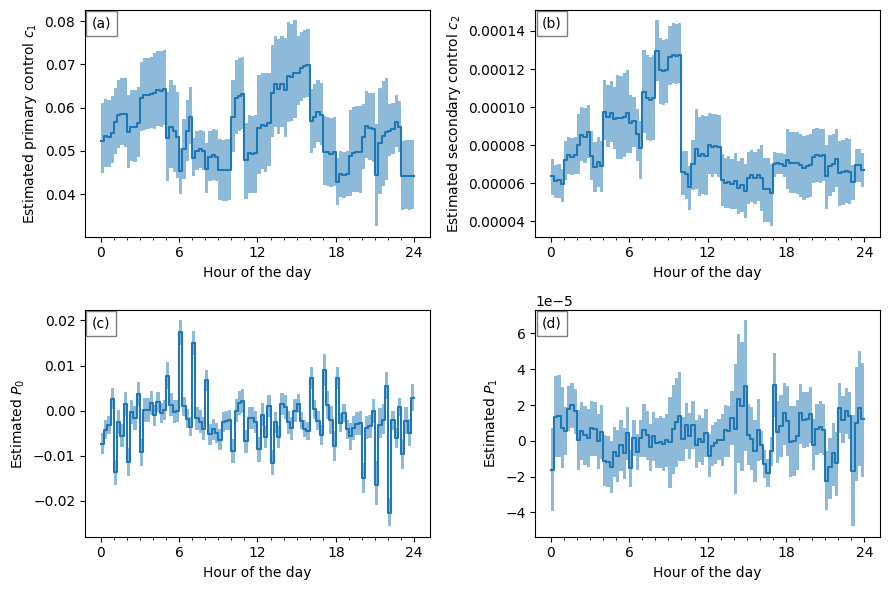

In [ ]:
# generates the combined plot of parameter daily profiles of c_1, c_2, P_0, and P_1
# the highlighted area around the mean line represents the 25th and 75th percentiles
fig, axs = plt.subplots(2, 2, figsize=(9, 6))
x = np.arange(0, 24 + 1/4, 1/4)

# set the x-axis ticks
for ax_row in axs:
    for ax in ax_row:
        ax.set_xticks([0, 6, 12, 18, 24])
        ax.set_xticks(np.arange(0, 25, 1), minor=True)
        ax.set_xlabel("Hour of the day")

# first subplot: daily profile of c_1
y = np.zeros(hours * 4 + 1)
for i in range(0, hours * 4):
    y[i] = np.nanmean(c1_means[:, i])
y[-1] = y[-2]
axs[0][0].plot(x, y, drawstyle="steps-post")
axs[0][0].fill_between(x, 
                       np.append(np.nanmean(c1_q25, axis=0), np.nanmean(c1_q25, axis=0)[-1]), 
                       np.append(np.nanmean(c1_q75, axis=0), np.nanmean(c1_q75, axis=0)[-1]), alpha=0.5, step="post")
axs[0][0].set_ylabel(r"Estimated primary control $c_1$")
axs[0][0].text(0.02, 0.97, "(a)", transform=axs[0][0].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))

# second subplot: daily profile of c_2
y = np.zeros(hours * 4 + 1)
for i in range(0, hours * 4):
    y[i] = np.nanmean(c2_means[:, i])
y[-1] = y[-2]
axs[0][1].plot(x, y, drawstyle="steps-post")
axs[0][1].fill_between(x, 
                       np.append(np.nanmean(c2_q25, axis=0), np.nanmean(c2_q25, axis=0)[-1]),
                       np.append(np.nanmean(c2_q75, axis=0), np.nanmean(c2_q75, axis=0)[-1]), alpha=0.5, step="post")
axs[0][1].set_ylabel(r"Estimated secondary control $c_2$")
axs[0][1].text(0.02, 0.97, "(b)", transform=axs[0][1].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))

# third subplot: daily profile of P_0
y = np.zeros(hours * 4 + 1)
for i in range(0, hours * 4):
    y[i] = np.nanmean(p0_means[:, i])
y[-1] = y[-2]
axs[1][0].plot(x, y, drawstyle="steps-post")
axs[1][0].fill_between(x, 
                       np.append(np.nanmean(p0_q25, axis=0), np.nanmean(p0_q25, axis=0)[-1]),
                       np.append(np.nanmean(p0_q75, axis=0), np.nanmean(p0_q75, axis=0)[-1]), alpha=0.5, step="post")
axs[1][0].set_ylabel(r"Estimated $P_0$")
axs[1][0].text(0.02, 0.97, "(c)", transform=axs[1][0].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))

# fourth subplot: daily profile of P_1
y = np.zeros(hours * 4 + 1)
for i in range(0, hours * 4):
    y[i] = np.nanmean(p1_means[:, i])
y[-1] = y[-2]
axs[1][1].plot(x, y, drawstyle="steps-post")
axs[1][1].fill_between(x, 
                       np.append(np.nanmean(p1_q25, axis=0), np.nanmean(p1_q25, axis=0)[-1]), 
                       np.append(np.nanmean(p1_q75, axis=0), np.nanmean(p1_q75, axis=0)[-1]), alpha=0.5, step="post")
axs[1][1].set_ylabel(r"Estimated $P_1$")
axs[1][1].text(0.02, 0.97, "(d)", transform=axs[1][1].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))

plt.tight_layout()
plt.savefig("figures/empirical_evaluation_CE_daily_profiles_daytime_specific.pdf", bbox_inches="tight", format="pdf")
plt.show()

### Daytime-specific Posteriors (60min)

In [4]:
number_of_samples = 500
time_span = 3600
days = 90
hours = 24 # 24 hours in a day
dt = 1.0 # because the divergence plots take too long for dt=0.01

In [5]:
# compute the data used for the daily parameter profiles. this includes the means and the 25th and 75th percentiles for each parameter and each hour of each day

start = datetime.datetime(2021, 1, 1, 0, 0, 0)

c1_means = np.zeros((days, hours))
c1_q25 = np.zeros((days, hours))
c1_q75 = np.zeros((days, hours))

c2_means = np.zeros((days, hours))
c2_q25 = np.zeros((days, hours))
c2_q75 = np.zeros((days, hours))

p0_means = np.zeros((days, hours))
p0_q25 = np.zeros((days, hours))
p0_q75 = np.zeros((days, hours))

p1_means = np.zeros((days, hours))
p1_q25 = np.zeros((days, hours))
p1_q75 = np.zeros((days, hours))

for j in range(0, days):
    day = start.day

    for i in range(0, hours):
        # read in the daytime-specific posterior
        in_s = open("out/posterior_NPE_3600s_hour_" + str(start.hour) + "_dt" + str(dt) + ".pickle", "rb")
        try:
            posterior_NPE = pickle.load(in_s)
        finally:
            in_s.close()

        end = start + datetime.timedelta(minutes=59, seconds=59)

        # we take a 60-minute long observation
        x_obs = df[str(start):str(end)]["angular_velocity"].to_numpy()
        
        # print current day and hour for debugging
        # print("Day: " + str(day) + ", Hour: " + str(start.hour))

        # if the observation is empty or contains NaNs, we skip it
        if (x_obs.size == 0 or np.any(np.isnan(x_obs))):
            c1_means[j][i] = np.nan
            c1_q25[j][i] = np.nan
            c1_q75[j][i] = np.nan

            c2_means[j][i] = np.nan
            c2_q25[j][i] = np.nan
            c2_q75[j][i] = np.nan

            p0_means[j][i] = np.nan
            p0_q25[j][i] = np.nan
            p0_q75[j][i] = np.nan

            p1_means[j][i] = np.nan
            p1_q25[j][i] = np.nan
            p1_q75[j][i] = np.nan

            start = start + datetime.timedelta(minutes=60)
            continue
        
        samples_NPE = sample_from_posterior(posterior_NPE, number_of_samples, x_obs)

        c1_means[j][i] = samples_NPE[:, 2].mean().item()
        c1_q25[j][i] = np.quantile(samples_NPE[:, 2].numpy(), 0.25)
        c1_q75[j][i] = np.quantile(samples_NPE[:, 2].numpy(), 0.75)
        
        c2_means[j][i] = samples_NPE[:, 3].mean().item()
        c2_q25[j][i] = np.quantile(samples_NPE[:, 3].numpy(), 0.25)
        c2_q75[j][i] = np.quantile(samples_NPE[:, 3].numpy(), 0.75)

        p0_means[j][i] = samples_NPE[:, 4].mean().item()
        p0_q25[j][i] = np.quantile(samples_NPE[:, 4].numpy(), 0.25)
        p0_q75[j][i] = np.quantile(samples_NPE[:, 4].numpy(), 0.75)

        p1_means[j][i] = samples_NPE[:, 5].mean().item()
        p1_q25[j][i] = np.quantile(samples_NPE[:, 5].numpy(), 0.25)
        p1_q75[j][i] = np.quantile(samples_NPE[:, 5].numpy(), 0.75)

        start = start + datetime.timedelta(minutes=60)

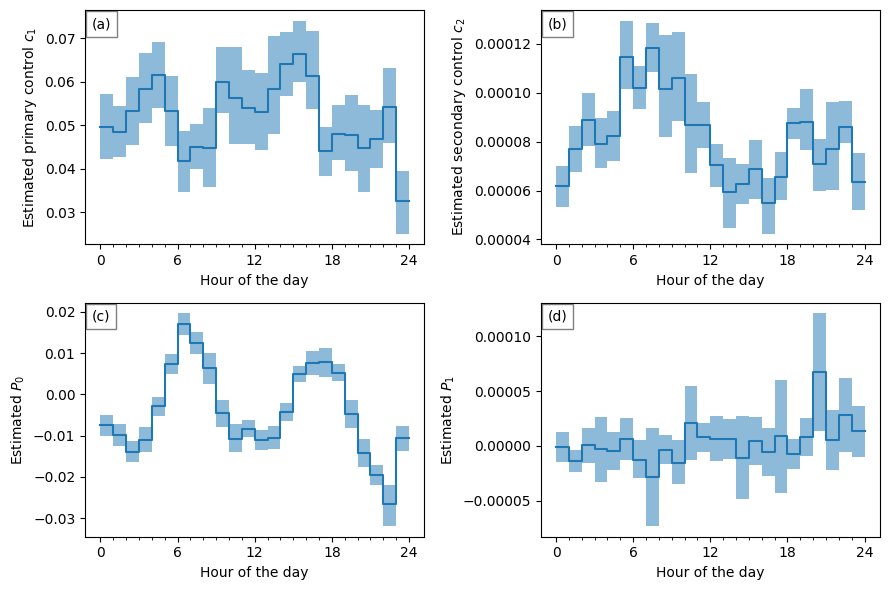

In [ ]:
# generates the combined plot of parameter daily profiles of c_1, c_2, P_0, and P_1
# the highlighted area around the mean line represents the 25th and 75th percentiles
fig, axs = plt.subplots(2, 2, figsize=(9, 6))
x = np.arange(0, 24 + 1)

# set the x-axis ticks
for ax_row in axs:
    for ax in ax_row:
        ax.set_xticks([0, 6, 12, 18, 24])
        ax.set_xticks(np.arange(0, 25, 1), minor=True)
        ax.set_xlabel("Hour of the day")

# first subplot: daily profile of c_1
y = np.zeros(hours + 1)
for i in range(0, hours):
    y[i] = np.nanmean(c1_means[:, i])
y[-1] = y[-2]
axs[0][0].plot(x, y, drawstyle="steps-post")
axs[0][0].fill_between(x, 
                       np.append(np.nanmean(c1_q25, axis=0), np.nanmean(c1_q25, axis=0)[-1]),
                       np.append(np.nanmean(c1_q75, axis=0), np.nanmean(c1_q75, axis=0)[-1]), alpha=0.5, step="post")
axs[0][0].set_ylabel(r"Estimated primary control $c_1$")
axs[0][0].text(0.02, 0.97, "(a)", transform=axs[0][0].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))

# second subplot: daily profile of c_2
y = np.zeros(hours + 1)
for i in range(0, hours):
    y[i] = np.nanmean(c2_means[:, i])
y[-1] = y[-2]
axs[0][1].plot(x, y, drawstyle="steps-post")
axs[0][1].fill_between(x, 
                       np.append(np.nanmean(c2_q25, axis=0), np.nanmean(c2_q25, axis=0)[-1]),
                       np.append(np.nanmean(c2_q75, axis=0), np.nanmean(c2_q75, axis=0)[-1]), alpha=0.5, step="post")
axs[0][1].set_ylabel(r"Estimated secondary control $c_2$")
axs[0][1].text(0.02, 0.97, "(b)", transform=axs[0][1].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))

# third subplot: daily profile of P_0
y = np.zeros(hours + 1)
for i in range(0, hours):
    y[i] = np.nanmean(p0_means[:, i])
y[-1] = y[-2]
axs[1][0].plot(x, y, drawstyle="steps-post")
axs[1][0].fill_between(x, 
                       np.append(np.nanmean(p0_q25, axis=0), np.nanmean(p0_q25, axis=0)[-1]),
                       np.append(np.nanmean(p0_q75, axis=0), np.nanmean(p0_q75, axis=0)[-1]), alpha=0.5, step="post")
axs[1][0].set_ylabel(r"Estimated $P_0$")
axs[1][0].text(0.02, 0.97, "(c)", transform=axs[1][0].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))

# fourth subplot: daily profile of P_1
y = np.zeros(hours + 1)
for i in range(0, hours):
    y[i] = np.nanmean(p1_means[:, i])
y[-1] = y[-2]
axs[1][1].plot(x, y, drawstyle="steps-post")
axs[1][1].fill_between(x, 
                       np.append(np.nanmean(p1_q25, axis=0), np.nanmean(p1_q25, axis=0)[-1]),
                       np.append(np.nanmean(p1_q75, axis=0), np.nanmean(p1_q75, axis=0)[-1]), alpha=0.5, step="post")
axs[1][1].set_ylabel(r"Estimated $P_1$")
axs[1][1].text(0.02, 0.97, "(d)", transform=axs[1][1].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))

plt.tight_layout()
plt.savefig("figures/empirical_evaluation_CE_daily_profiles_daytime_specific_60min.pdf", bbox_inches="tight", format="pdf")
plt.show()

#### Parameter Estimation with Constrained Frequency Control

In [5]:
number_of_samples = 500
days = 90
hours = 24 # 24 hours in a day

In [6]:
# read in the prior
in_s = open("out/prior_NPE_inertia_60s_dt0.01.pickle", "rb")
try:
    prior_inertia = pickle.load(in_s)
finally:
    in_s.close()

# read in the posterior
in_s = open("out/posterior_NPE_inertia_60s_dt0.01.pickle", "rb")
try:
    posterior_NPE_inertia = pickle.load(in_s)
finally:
    in_s.close()

In [7]:
# daily profiles of parameter estimates

start = datetime.datetime(2021, 1, 1, 0, 0, 0)

p0_means = np.zeros((days, hours))
p0_q25 = np.zeros((days, hours))
p0_q75 = np.zeros((days, hours))

p1_means = np.zeros((days, hours))
p1_q25 = np.zeros((days, hours))
p1_q75 = np.zeros((days, hours))

H_means = np.zeros((days, hours))
H_q25 = np.zeros((days, hours))
H_q75 = np.zeros((days, hours))

for j in range(0, days):
    day = start.day

    for i in range(0, hours):
        end = start + datetime.timedelta(seconds=59)

        # we take a 1-minute long observation
        x_obs = df[str(start):str(end)]["angular_velocity"].to_numpy()
        
        # if the observation is empty or contains NaNs, we skip it
        if (x_obs.size == 0 or np.any(np.isnan(x_obs))):
            p0_means[j][i] = np.nan
            p0_q25[j][i] = np.nan
            p0_q75[j][i] = np.nan

            p1_means[j][i] = np.nan
            p1_q25[j][i] = np.nan
            p1_q75[j][i] = np.nan

            H_means[j][i] = np.nan
            H_q25[j][i] = np.nan
            H_q75[j][i] = np.nan

            start = start + datetime.timedelta(hours=1)
            continue
        
        samples_NPE = sample_from_posterior(posterior_NPE_inertia, number_of_samples, x_obs)

        p0_means[j][i] = samples_NPE[:, 1].mean().item()
        p0_q25[j][i] = np.quantile(samples_NPE[:, 1].numpy(), 0.25)
        p0_q75[j][i] = np.quantile(samples_NPE[:, 1].numpy(), 0.75)

        p1_means[j][i] = samples_NPE[:, 2].mean().item()
        p1_q25[j][i] = np.quantile(samples_NPE[:, 2].numpy(), 0.25)
        p1_q75[j][i] = np.quantile(samples_NPE[:, 2].numpy(), 0.75)

        H_means[j][i] = samples_NPE[:, 4].mean().item()
        H_q25[j][i] = np.quantile(samples_NPE[:, 4].numpy(), 0.25)
        H_q75[j][i] = np.quantile(samples_NPE[:, 4].numpy(), 0.75)

        start = start + datetime.timedelta(hours=1)


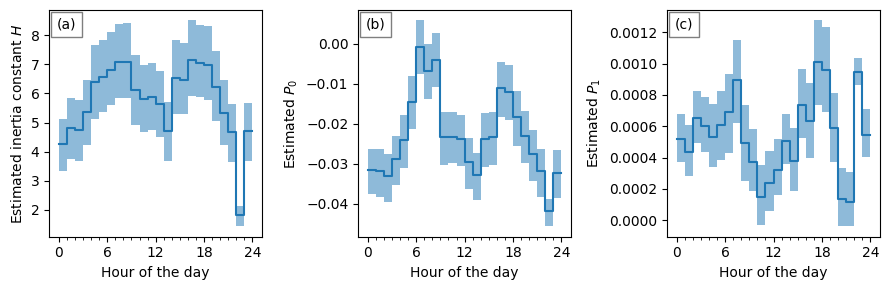

In [13]:
# generate the combined plot of parameter daily profiles
# the highlighted area around the mean line represents the 25th and 75th percentiles
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
x = np.arange(0, 24 + 1)

# set the x-axis ticks
for ax in axs:
    ax.set_xticks([0, 6, 12, 18, 24])
    ax.set_xticks(np.arange(0, 25, 1), minor=True)
    ax.set_xlabel("Hour of the day")

# first subplot: daily profile of H
y = np.zeros(hours + 1)
for i in range(0, hours):
    y[i] = np.nanmean(H_means[:, i])
y[-1] = y[-2]
axs[0].plot(x, y, drawstyle="steps-post")
axs[0].fill_between(x, 
                    np.append(np.nanmean(H_q25, axis=0), np.nanmean(H_q25, axis=0)[-1]), 
                    np.append(np.nanmean(H_q75, axis=0), np.nanmean(H_q75, axis=0)[-1]), alpha=0.5, step="post")
axs[0].set_ylabel(r"Estimated inertia constant $H$")
axs[0].text(0.035, 0.965, "(a)", transform=axs[0].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))

# second subplot: daily profile of P_0
y = np.zeros(hours + 1)
for i in range(0, hours):
    y[i] = np.nanmean(p0_means[:, i])
y[-1] = y[-2]
axs[1].plot(x, y, drawstyle="steps-post")
axs[1].fill_between(x, 
                    np.append(np.nanmean(p0_q25, axis=0), np.nanmean(p0_q25, axis=0)[-1]),
                    np.append(np.nanmean(p0_q75, axis=0), np.nanmean(p0_q75, axis=0)[-1]), alpha=0.5, step="post")
axs[1].set_ylabel(r"Estimated $P_0$")
axs[1].text(0.035, 0.965, "(b)", transform=axs[1].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))

# third subplot: daily profile of P_1
y = np.zeros(hours + 1)
for i in range(0, hours):
    y[i] = np.nanmean(p1_means[:, i])
y[-1] = y[-2]
axs[2].plot(x, y, drawstyle="steps-post")
axs[2].fill_between(x, 
                    np.append(np.nanmean(p1_q25, axis=0), np.nanmean(p1_q25, axis=0)[-1]),
                    np.append(np.nanmean(p1_q75, axis=0), np.nanmean(p1_q75, axis=0)[-1]), alpha=0.5, step="post")
axs[2].set_ylabel(r"Estimated $P_1$")
axs[2].text(0.035, 0.965, "(c)", transform=axs[2].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))

plt.tight_layout()
plt.savefig("figures/empirical_evaluation_CE_inertia_daily_profiles.pdf", bbox_inches="tight", format="pdf")
plt.show()

In [ ]:
# the divergence plot can be found in the external python-files due to the need for multiprocessing.

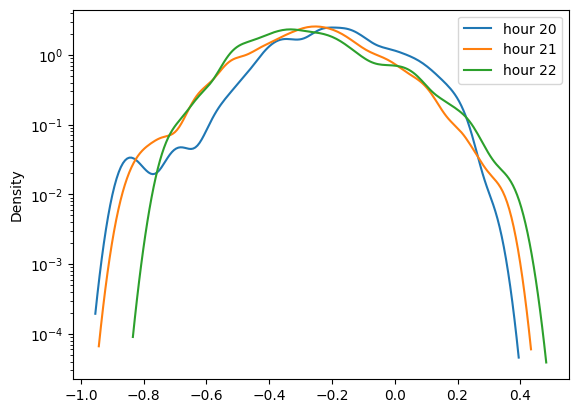

In [ ]:
## Let"s look at some observations to find out why the estimation of H for hour 22 is different to the other hours

start = datetime.datetime(2021, 1, 1, 20, 0, 0)
data_20 = np.zeros((90, 60))
for i in range(0, 90):
    data_20[i] = df[str(start):str(start + datetime.timedelta(seconds=59))]["angular_velocity"]
    start = start + datetime.timedelta(hours=24)

start = datetime.datetime(2021, 1, 1, 21, 0, 0)
data_21 = np.zeros((90, 60))
for i in range(0, 90):
    data_21[i] = df[str(start):str(start + datetime.timedelta(seconds=59))]["angular_velocity"]
    start = start + datetime.timedelta(hours=24)

start = datetime.datetime(2021, 1, 1, 22, 0, 0)
data_22 = np.zeros((90, 60))
for i in range(0, 90):
    data_22[i] = df[str(start):str(start + datetime.timedelta(seconds=59))]["angular_velocity"]
    start = start + datetime.timedelta(hours=24)

sns.kdeplot(data_20.flatten(), label="hour 20")
sns.kdeplot(data_21.flatten(), label="hour 21")
sns.kdeplot(data_22.flatten(), label="hour 22")
plt.yscale("log")
plt.legend()
plt.show()

##### Issue with empirical load and generation

In [4]:
# read in the dataset with load and generation features for CE
df_power = pd.read_hdf("input_actual.h5")
df_power.index = pd.to_datetime(df_power.index.astype(str), utc=True)

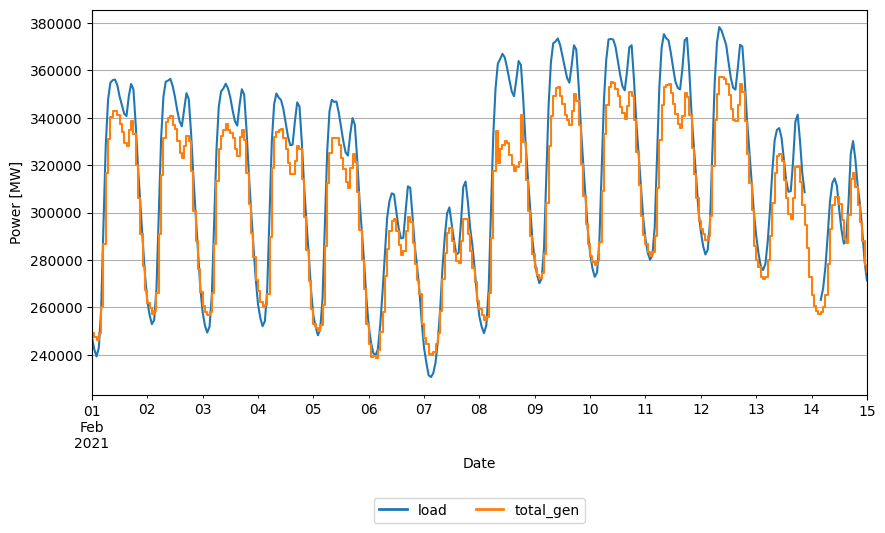

In [5]:
# generate the plot of the load and generation data for two weeks
fix, ax = plt.subplots(1, 1, figsize=(10, 5))
start = datetime.datetime(2021, 2, 1, 0, 0, 0)
hours = 24 * 7 * 2 # for two weeks
end = start + datetime.timedelta(hours=hours)
df2_power = df_power[str(start):str(end)][["total_gen", "load"]]
df2_power["load"].plot()
df2_power["total_gen"].plot(drawstyle="steps-post")

# plot settings
plt.xlabel("Date")
plt.ylabel("Power [MW]")
legend_handles = [Line2D([0], [0], color="tab:blue", lw=2, label="load"),
                  Line2D([0], [0], color="tab:orange", lw=2, label="total_gen")]
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(0.5, -0.25), ncol=2)
plt.grid()
plt.savefig("figures/CE_2021_load_gen.pdf", bbox_inches="tight", format="pdf")
plt.show()

#### Best and Worst Simulations for a trajectory example (60min)

In [18]:
number_of_samples = 2000
time_span = 3600
dt = 1.0

In [19]:
# read in the posterior
in_s = open("out/posterior_NPE_3600s_dt" + str(dt) + ".pickle", "rb")
try:
    posterior_NPE = pickle.load(in_s)
finally:
    in_s.close()

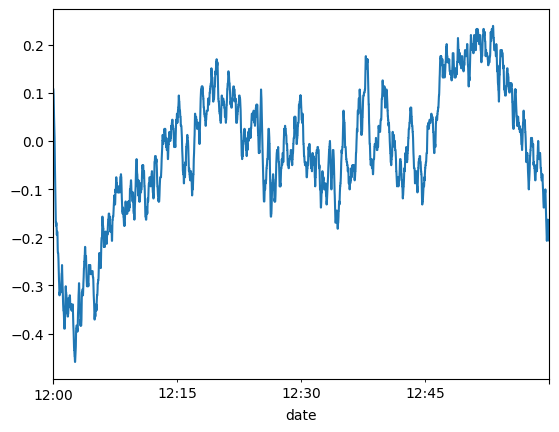

In [20]:
# choosing an observation

start = datetime.datetime(2021, 3, 1, 12, 00, 0)
end = start + datetime.timedelta(minutes=59, seconds=59)
plot_angular_velocity(df, start, end)
x_obs = df[str(start):str(end)]["angular_velocity"].to_numpy()

In [21]:
# sample from the posterior and generate simulations
samples_NPE = sample_from_posterior(posterior_NPE, number_of_samples, x_obs)
theta = build_theta_for_batch_simulator_from_samples_tensor(samples_NPE)
simulation_results_posterior_NPE = batch_simulator(theta, time_span, dt, n_workers)

In [22]:
# compute the Jensen-Shannon divergences between the observation and the simulations
with ProcessPoolExecutor() as executor:
    futures = [executor.submit(divergences.jensen_shannon_div, gaussian_kde(x_obs), gaussian_kde(sim)) for sim in simulation_results_posterior_NPE[1]]
    js_divergences = [future.result() for future in futures]

In [23]:
# find the minimum and maximum Jensen-Shannon divergence
argmax = np.argmax(js_divergences)
argmin = np.argmin(js_divergences)

print("max JS divergence: ", max(js_divergences))
print("argmax JS divergence: ", argmax)
print("min JS divergence: ", min(js_divergences))
print("argmin JS divergence: ", argmin)
print("mean JS divergence: ", np.nanmean(js_divergences))

max JS divergence:  0.6313639463994707
argmax JS divergence:  1605
min JS divergence:  0.010766856780335423
argmin JS divergence:  463
mean JS divergence:  0.23785600266311926


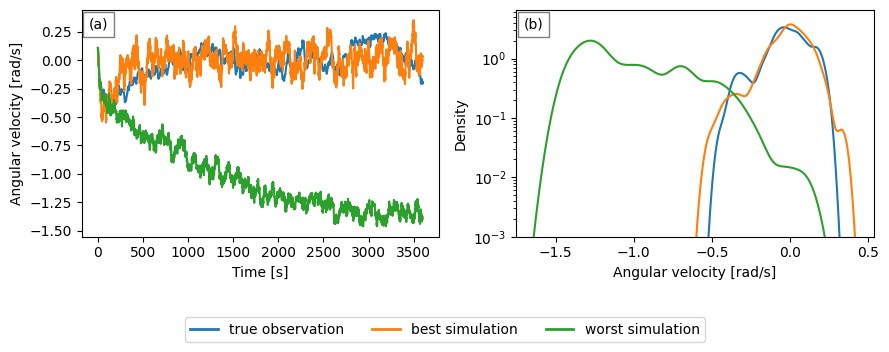

In [28]:
# combined plot of angular velocity trajectories and their kernel density estimates
fig, axs = plt.subplots(1, 2, figsize=(9, 3))

# first subplot: angular velocity trajectories of the observation, the best simulation, and the worst simulation
axs[0].plot(x_obs)
axs[0].plot(simulation_results_posterior_NPE[1][argmin])
axs[0].plot(simulation_results_posterior_NPE[1][argmax])
axs[0].set_xlabel("Time [s]")
axs[0].set_ylabel("Angular velocity [rad/s]")
axs[0].text(0.02, 0.965, "(a)", transform=axs[0].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))


# second subplot: kernel density estimates for the observation, the best simulation, and the worst simulation
sns.kdeplot(x_obs, ax=axs[1])
sns.kdeplot(simulation_results_posterior_NPE[1][argmin], ax=axs[1])
sns.kdeplot(simulation_results_posterior_NPE[1][argmax], ax=axs[1])
axs[1].set_yscale("log")
axs[1].set_ylim(bottom=1e-3)
axs[1].set_xlabel("Angular velocity [rad/s]")
axs[1].text(0.02, 0.965, "(b)", transform=axs[1].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))


# legend settings
legend_handles = [Line2D([0], [0], color="tab:blue", lw=2, label="true observation"),
                    Line2D([0], [0], color="tab:orange", lw=2, label="best simulation"),
                    Line2D([0], [0], color="tab:green", lw=2, label="worst simulation")]
fig.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=3)

plt.tight_layout()
plt.savefig("figures/observation_best_worst.pdf", bbox_inches="tight", format="pdf")
plt.show()

#### Best and worst simulation for example trajectory (60s)

In [29]:
number_of_samples = 2000
time_span = 60
dt = 0.01

In [30]:
# read in the posterior
in_s = open("out/posterior_NPE_inertia_60s_dt" + str(dt) + ".pickle", "rb")
try:
    posterior_NPE_inertia = pickle.load(in_s)
finally:
    in_s.close()

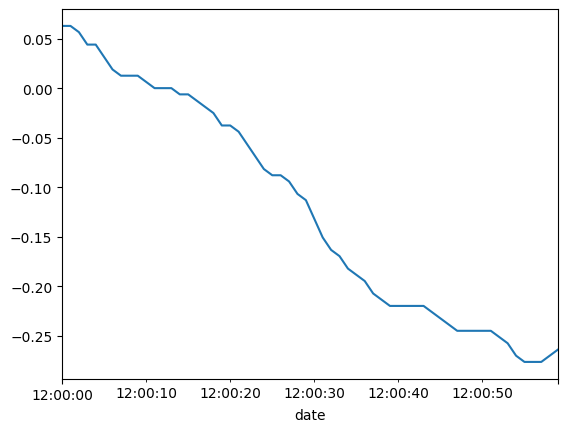

In [31]:
# set an observation

start = datetime.datetime(2021, 2, 1, 12, 00, 0)
end = start + datetime.timedelta(seconds=59)
plot_angular_velocity(df, start, end)
x_obs = df[str(start):str(end)]["angular_velocity"].to_numpy()

In [32]:
# sample from the posterior and generate simulations
samples_NPE = sample_from_posterior(posterior_NPE_inertia, number_of_samples, x_obs)
theta = build_theta_for_batch_simulator_from_samples_tensor(samples_NPE, inertia=True)
simulation_results_posterior_NPE = batch_simulator(theta, time_span, dt, n_workers)[1][:, ::int(1/dt)]

In [33]:
# compute the Jensen-Shannon divergences between the observation and the simulations
with ProcessPoolExecutor() as executor:
    futures = [executor.submit(divergences.jensen_shannon_div, gaussian_kde(x_obs), gaussian_kde(sim)) for sim in simulation_results_posterior_NPE]
    js_divergences = [future.result() for future in futures]

In [35]:
# find the minimum and maximum Jensen-Shannon divergence
argmax = np.argmax(js_divergences)
argmin = np.argmin(js_divergences)

print("max JS divergence: ", max(js_divergences))
print("argmax JS divergence: ", argmax)
print("min JS divergence: ", min(js_divergences))
print("argmin JS divergence: ", argmin)
print("mean JS divergence: ", np.nanmean(js_divergences))

max JS divergence:  0.43079164757544114
argmax JS divergence:  1731
min JS divergence:  0.0011107202736895898
argmin JS divergence:  1325
mean JS divergence:  0.042141742466483126


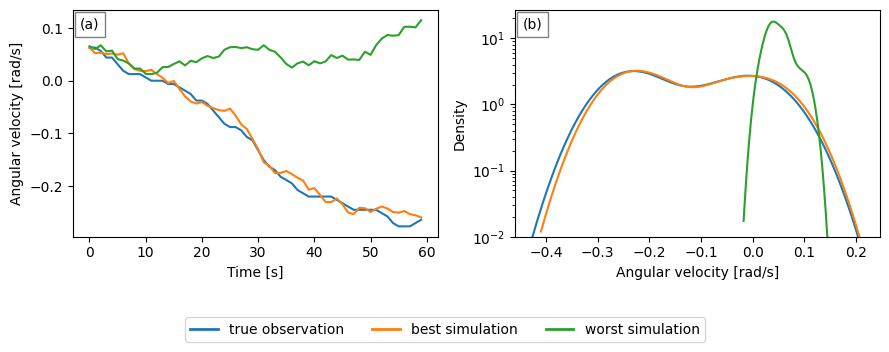

In [38]:
# combined plot of angular velocity trajectories and their kernel density estimates
fig, axs = plt.subplots(1, 2, figsize=(9, 3))

# first subplot: angular velocity trajectories of the observation, the best simulation, and the worst simulation
axs[0].plot(x_obs)
axs[0].plot(simulation_results_posterior_NPE[argmin])
axs[0].plot(simulation_results_posterior_NPE[argmax])
axs[0].set_xlabel("Time [s]")
axs[0].set_ylabel("Angular velocity [rad/s]")
axs[0].text(0.02, 0.965, "(a)", transform=axs[0].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))


# second subplot: kernel density estimates for the observation, the best simulation, and the worst simulation
sns.kdeplot(x_obs, ax=axs[1])
sns.kdeplot(simulation_results_posterior_NPE[argmin], ax=axs[1])
sns.kdeplot(simulation_results_posterior_NPE[argmax], ax=axs[1])
axs[1].set_yscale("log")
axs[1].set_ylim(bottom=1e-2)
axs[1].set_xlabel("Angular velocity [rad/s]")
axs[1].text(0.02, 0.965, "(b)", transform=axs[1].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))


# legend settings
legend_handles = [Line2D([0], [0], color="tab:blue", lw=2, label="true observation"),
                    Line2D([0], [0], color="tab:orange", lw=2, label="best simulation"),
                    Line2D([0], [0], color="tab:green", lw=2, label="worst simulation")]
fig.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=3)

plt.tight_layout()
plt.savefig("figures/observation_best_worst_inertia.pdf", bbox_inches="tight", format="pdf")
plt.show()